In [1]:
import config
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display
import json
import datetime

from utils.data_exploration_utils import plot_hist, scatterplot, barplots

In [2]:
today = datetime.date.today()

proc_dir = config.PROC_DATA_PATH

folder = "2025-07-14_data_exploration"
kl_file = "inmodi_data_personalinformation_kl.csv"
kl_filepath = os.path.join(proc_dir, folder, kl_file)

kl = pd.read_csv(kl_filepath)

folder = "2025-07-23_hdbscan"

save_dir = os.path.join(proc_dir, folder + "_eval")
os.makedirs(save_dir, exist_ok=True)

filepath = os.path.join(proc_dir, folder)

for f in os.listdir(filepath):
    if os.path.isdir(os.path.join(filepath, f)):
        if f == "run59":
            for file in os.listdir(os.path.join(filepath, f)):
                if file.endswith("hdbscan_scaled.csv"):
                    print(f"Processing file: {file}")
                    df = pd.read_csv(os.path.join(filepath, f, file))
                    display(df.head())
                elif file.endswith("hdbscan_scaled_wKL.csv"):
                    df_kl = pd.read_csv(os.path.join(filepath, f, file))
    else:
        continue

Processing file: 2025-07-23_hdbscan_run59_umap_hdbscan_scaled.csv


,id,cluster_label,probability
0,IM0001_1_left,2,0.941354
1,IM0002_1_left,2,1.000000
2,IM0004_1_left,5,1.000000
3,IM0005_1_left,13,0.929306
4,IM0008_1_left,5,0.577599


In [3]:
noise_points = list(set(list(df[df['cluster_label'] == -1]['id'])))

In [4]:
kl[kl['name'].isin(noise_points)]['KL-Score'].value_counts()

KL-Score
0.0    36
1.0    26
2.0    11
4.0     3
3.0     2
Name: count, dtype: int64

# Preprocessing

In [5]:
df_merged = kl.merge(df, left_on='name', right_on='id', how='left')

display(df_merged.head())

,record_id,visit,side,pain,age,ce_height,ce_weight,ce_bmi,ce_fm,gender,...,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol,name,KL-Score,id,cluster_label,probability
0,IM0001,1,l,0.0,41,183.0,82.1,24.5,18.5,male,...,100.0,100.0,100.0,100.0,100.0,IM0001_1_left,0.0,IM0001_1_left,2.0,0.941354
1,IM0002,1,l,0.0,40,175.0,72.9,23.8,20.6,male,...,100.0,68.0,100.0,100.0,100.0,IM0002_1_left,0.0,IM0002_1_left,2.0,1.000000
2,IM0004,1,l,0.0,55,151.0,55.2,24.2,35.8,female,...,100.0,61.0,95.0,100.0,100.0,IM0004_1_left,0.0,IM0004_1_left,5.0,1.000000
3,IM0005,1,l,0.0,46,184.5,98.5,28.9,27.5,male,...,86.0,46.0,70.0,97.0,81.0,IM0005_1_left,0.0,IM0005_1_left,13.0,0.929306
4,IM0008,1,l,0.0,51,166.0,71.5,25.9,35.4,female,...,92.0,68.0,90.0,100.0,88.0,IM0008_1_left,1.0,IM0008_1_left,5.0,0.577599


# Correlation

## Correlation with KL-Score and Pain

Calculating pearson correlation...


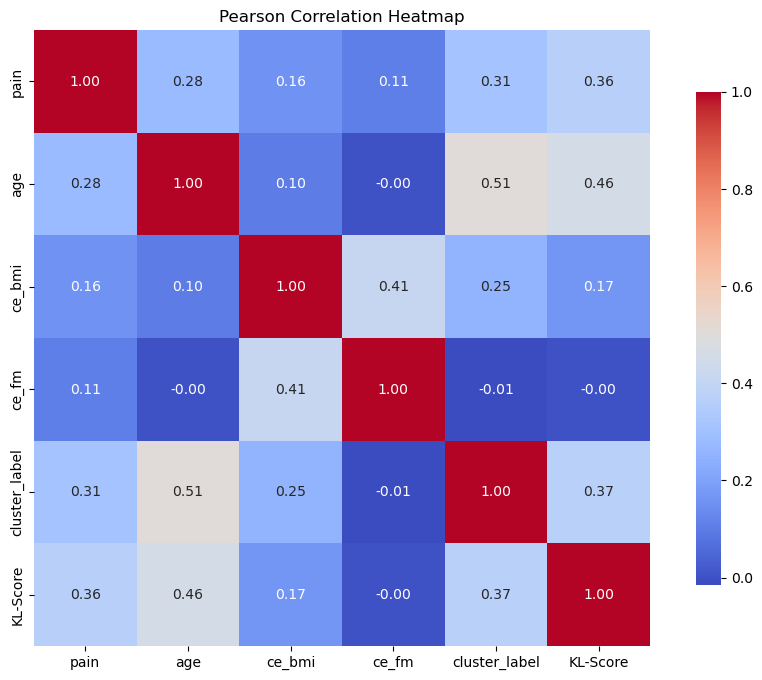

Calculating kendall correlation...


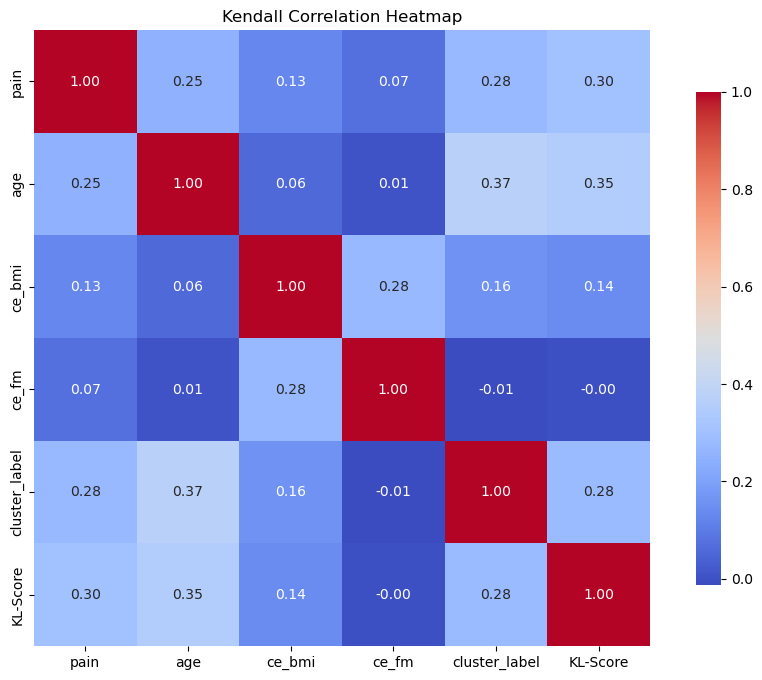

Calculating spearman correlation...


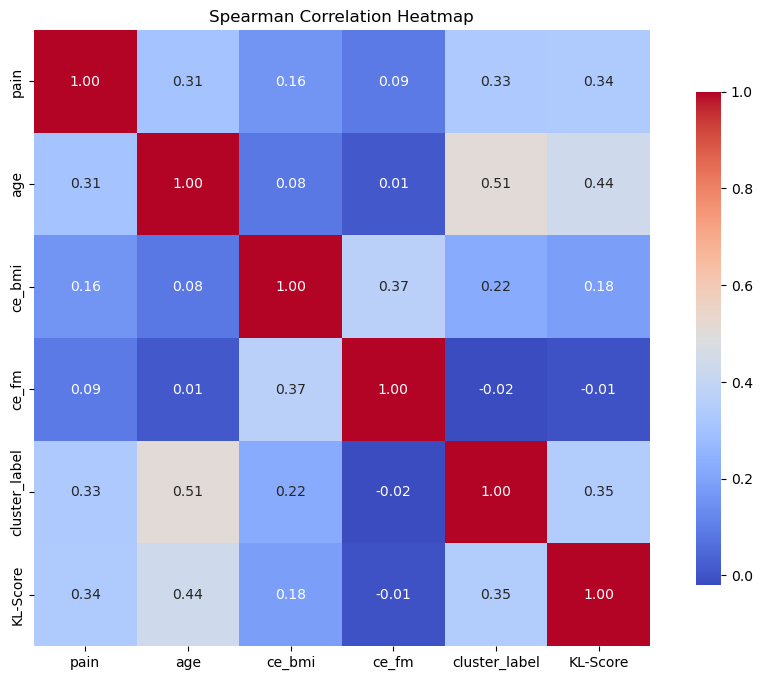

In [6]:
columns_corr = ['pain', 'age',
       'ce_bmi', 'ce_fm',  'cluster_label', 'KL-Score'] 

corr_types = ['pearson', 'kendall', 'spearman']
for corr in corr_types:
    print(f"Calculating {corr} correlation...")

    df_merged_corr = df_merged[columns_corr].corr(method=corr)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_merged_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f"{corr.capitalize()} Correlation Heatmap")
    #plt.savefig(os.path.join(img_save_dir, f"{corr}corr.png"))
    plt.show()

In [7]:
#'label' is ground truth

df_merged2 = df_merged.copy()
df_merged2 = df_merged2.dropna(subset=['cluster_label', 'KL-Score', 'pain'])

res = stats.spearmanr(df_merged2['cluster_label'].tolist(), df_merged2['KL-Score'].tolist())

print(f"Spearman correlation between cluster label and KL-Score: {res[0]:.3f}")

res = stats.spearmanr(df_merged2['cluster_label'].tolist(), df_merged2['pain'].tolist())
print(f"Spearman correlation between cluster label and pain: {res[0]:.3f}")

Spearman correlation between cluster label and KL-Score: 0.345
Spearman correlation between cluster label and pain: 0.328


In [8]:
columns_corr.remove('cluster_label')

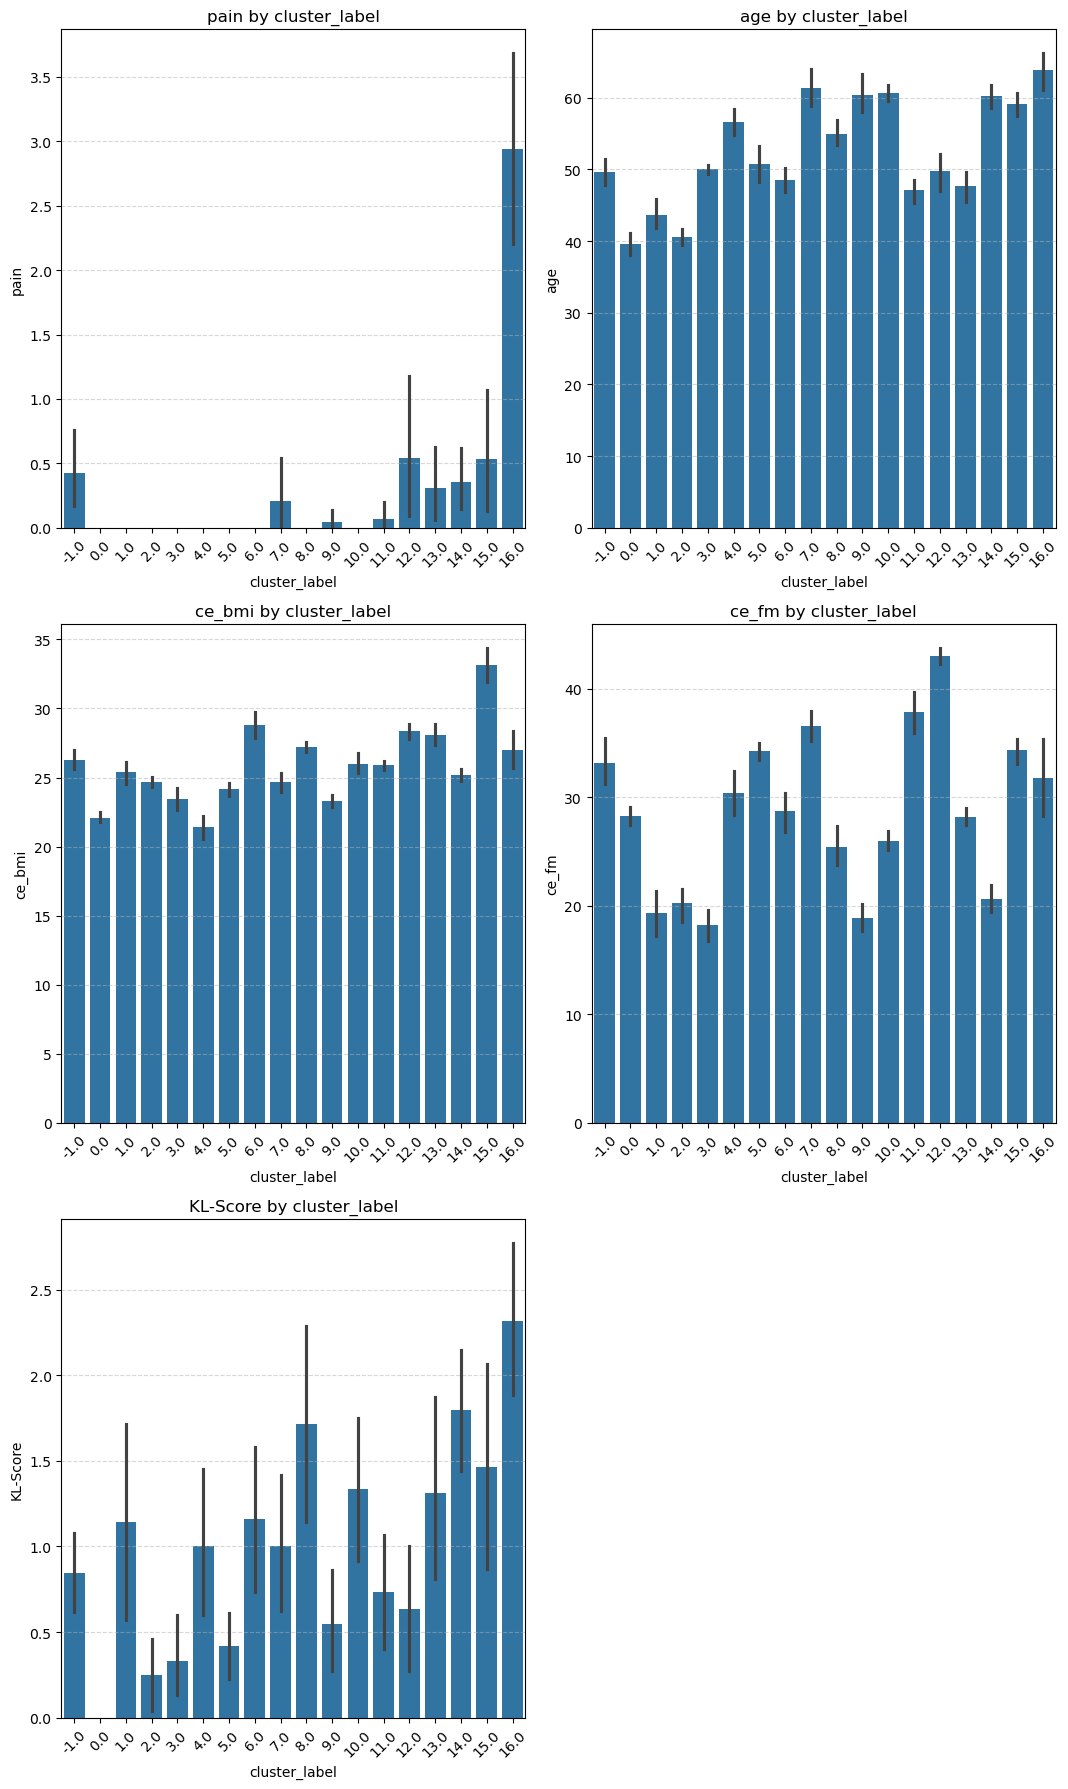

In [9]:
barplots(df_merged, y_list=columns_corr, x='cluster_label', hue=None, figsize = (6, 6), savepath=None)

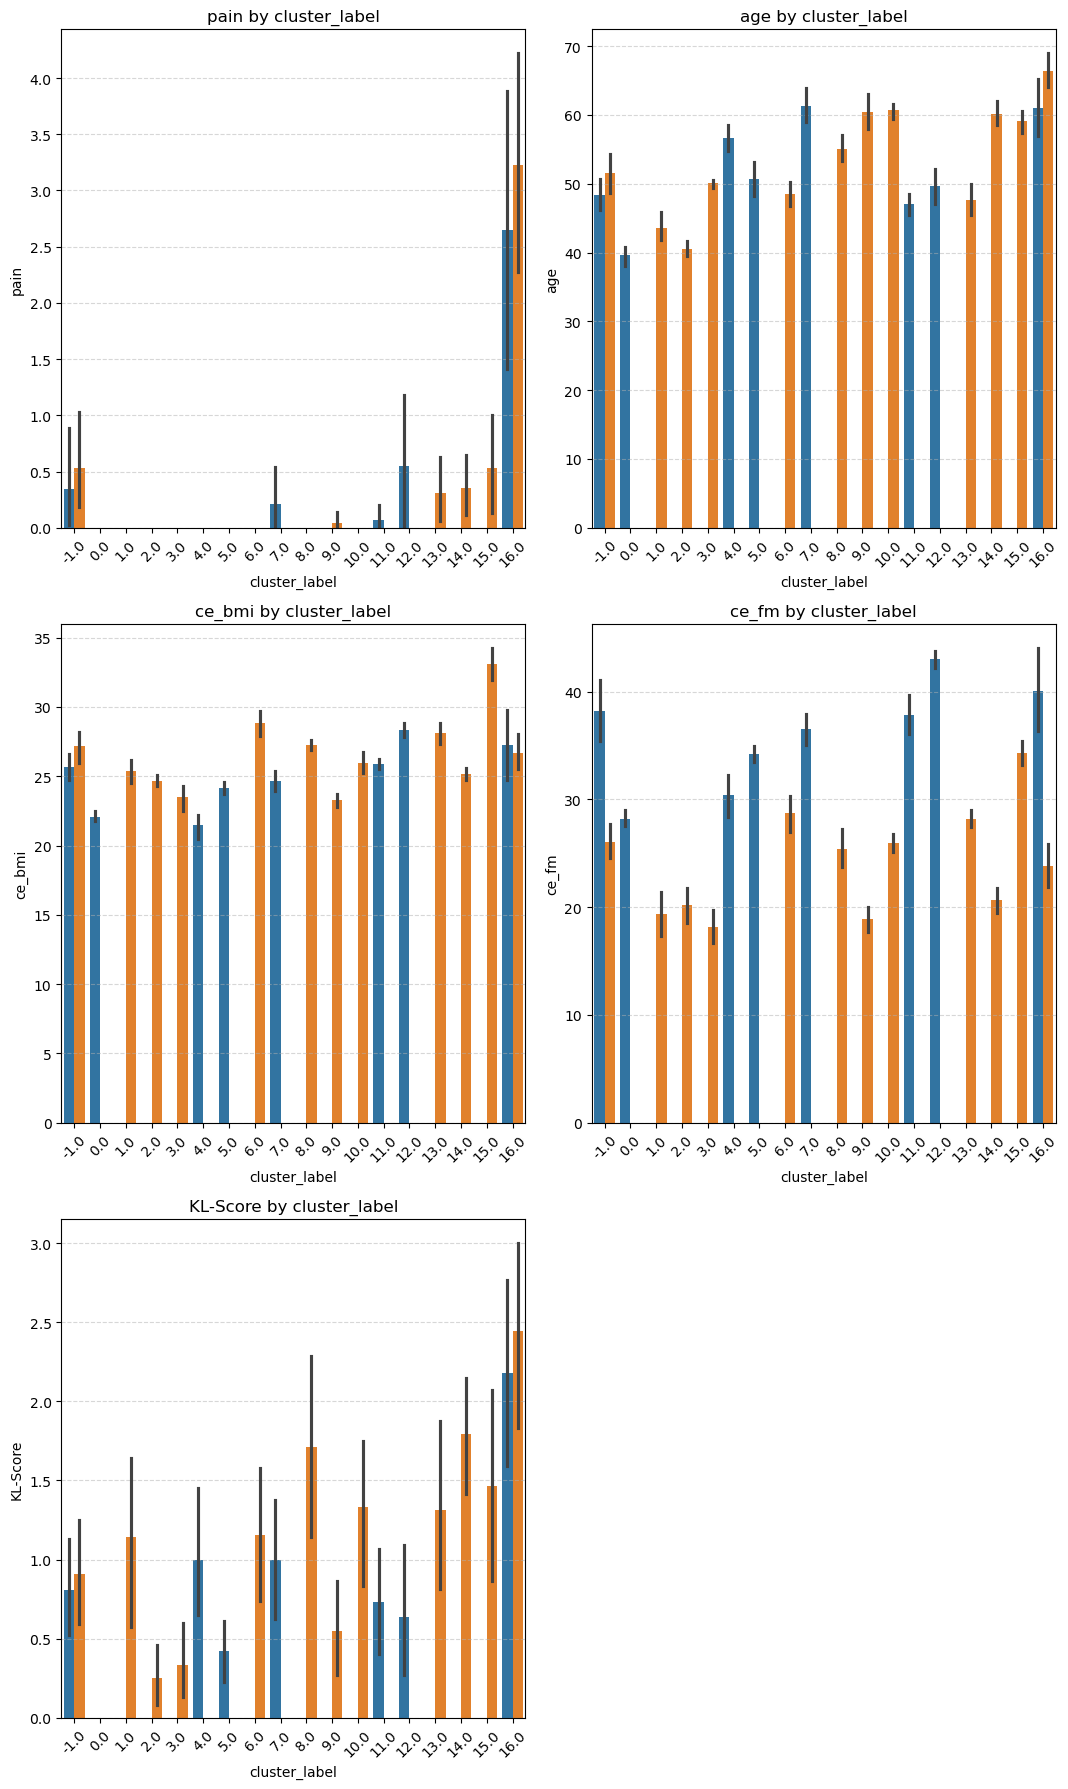

In [10]:
barplots(df_merged, y_list=columns_corr, x='cluster_label', hue='gender', figsize = (6, 6), savepath=None)

# Get examples

In [22]:
# Give me a df showing which clusters have which min max KL-Score
kl_diffs = df_merged.groupby('cluster_label')['KL-Score'].agg(['min', 'max'])
kl_diffs.sort_values('max', ascending=False, inplace=True)

In [23]:
kl_diffs

,min,max
cluster_label,,
-1.0,0.0,4.0
16.0,0.0,4.0
15.0,0.0,4.0
14.0,0.0,4.0
13.0,0.0,3.0
1.0,0.0,3.0
8.0,0.0,3.0
4.0,0.0,3.0
7.0,0.0,3.0


In [15]:
#for each cluster label give me 2 examples with different KL-Score

clusters = df_merged['cluster_label'].unique()
sorted_clusters = sorted(clusters)
for cluster in sorted_clusters:
    print(f"Cluster {cluster}:")
    cluster_df = df_merged[df_merged['cluster_label'] == cluster]
    
    if len(cluster_df) > 0:
        for kl_score in cluster_df['KL-Score'].unique():
            subset = cluster_df[cluster_df['KL-Score'] == kl_score]
            if len(subset) >= 2:
                examples = subset.sample(n=2, random_state=42)
                print(f"  KL-Score {kl_score}:")
                display(examples[['name', 'id', 'KL-Score', 'pain', 'age', 'ce_bmi', 'ce_fm']])
            else:
                examples = subset
                print(f"  KL-Score {kl_score}:")
                display(examples[['name', 'id', 'KL-Score', 'pain', 'age', 'ce_bmi', 'ce_fm']])
    else:
        print("  No data available for this cluster.")


Cluster -1.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
196,IM2559_2_left,IM2559_2_left,1.0,0.0,51,28.7,44.1
308,IM2559_1_right,IM2559_1_right,1.0,0.0,51,27.7,42.1


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
437,IM3022_2_right,IM3022_2_right,0.0,0.0,56,24.3,34.8
165,IM1560_2_left,IM1560_2_left,0.0,0.0,51,27.1,30.5


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
168,IM1572_2_left,IM1572_2_left,2.0,0.0,43,25.3,68.6
46,IM1536_1_left,IM1536_1_left,2.0,0.0,42,21.6,21.7


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
216,IM3022_2_left,IM3022_2_left,3.0,0.0,56,24.3,34.8
86,IM2523_1_left,IM2523_1_left,3.0,0.0,45,25.4,25.1


  KL-Score 4.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
105,IM3005_1_left,IM3005_1_left,4.0,1.0,70,30.3,44.1
110,IM3011_1_left,IM3011_1_left,4.0,1.0,66,28.4,25.7


Cluster 0.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
349,IM0015_2_right,IM0015_2_right,0.0,0.0,39,21.5,27.5
11,IM0015_1_left,IM0015_1_left,0.0,0.0,39,21.9,27.7


Cluster 1.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
98,IM2594_1_left,IM2594_1_left,1.0,0.0,43,22.1,11.5
267,IM1546_1_right,IM1546_1_right,1.0,0.0,42,25.8,17.7


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
84,IM2511_1_left,IM2511_1_left,0.0,0.0,41,26.0,22.3
425,IM2609_2_right,IM2609_2_right,0.0,0.0,42,25.1,17.6


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
172,IM2004_2_left,IM2004_2_left,3.0,0.0,42,26.7,22.8
62,IM2004_1_left,IM2004_1_left,3.0,0.0,42,27.4,24.4


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
280,IM2004_1_right,IM2004_1_right,2.0,0.0,42,27.4,24.4
302,IM2511_1_right,IM2511_1_right,2.0,0.0,41,26.0,22.3


Cluster 2.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
0,IM0001_1_left,IM0001_1_left,0.0,0.0,41,24.5,18.5
20,IM1005_1_left,IM1005_1_left,0.0,0.0,42,27.1,26.5


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
75,IM2040_1_left,IM2040_1_left,2.0,0.0,41,24.0,18.1


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
233,IM0019_1_right,IM0019_1_right,1.0,0.0,47,24.8,24.1
293,IM2040_1_right,IM2040_1_right,1.0,0.0,41,24.0,18.1


Cluster 3.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
128,IM0014_2_left,IM0014_2_left,1.0,0.0,51,20.1,17.5
348,IM0014_2_right,IM0014_2_right,1.0,0.0,51,20.1,17.5


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
397,IM2013_2_right,IM2013_2_right,0.0,0.0,50,25.1,21.4
33,IM1046_1_left,IM1046_1_left,0.0,0.0,47,23.6,21.0


Cluster 4.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
366,IM1041_2_right,IM1041_2_right,1.0,0.0,57,19.6,27.4
43,IM1526_1_left,IM1526_1_left,1.0,0.0,57,23.0,31.9


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
30,IM1041_1_left,IM1041_1_left,0.0,0.0,57,21.5,32.3
71,IM2023_1_left,IM2023_1_left,0.0,0.0,57,22.0,31.4


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
297,IM2057_1_right,IM2057_1_right,2.0,0.0,56,22.8,36.5
79,IM2057_1_left,IM2057_1_left,2.0,0.0,56,22.8,36.5


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
311,IM2576_1_right,IM2576_1_right,3.0,0.0,60,23.1,31.2
214,IM3016_2_left,IM3016_2_left,3.0,0.0,66,20.2,25.3


Cluster 5.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
2,IM0004_1_left,IM0004_1_left,0.0,0.0,55,24.2,35.8
66,IM2012_1_left,IM2012_1_left,0.0,0.0,49,24.1,34.8


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
223,IM0009_1_right,IM0009_1_right,1.0,0.0,46,22.4,32.4
4,IM0008_1_left,IM0008_1_left,1.0,0.0,51,25.9,35.4


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
69,IM2016_1_left,IM2016_1_left,2.0,0.0,52,26.4,35.7


Cluster 6.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
6,IM0010_1_left,IM0010_1_left,0.0,0.0,46,31.6,32.5
21,IM1007_1_left,IM1007_1_left,0.0,0.0,42,29.0,31.4


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
53,IM1560_1_left,IM1560_1_left,1.0,0.0,51,28.3,28.3
139,IM1011_2_left,IM1011_2_left,1.0,0.0,49,25.2,21.0


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
65,IM2011_1_left,IM2011_1_left,2.0,0.0,49,29.3,28.3
70,IM2021_1_left,IM2021_1_left,2.0,0.0,57,28.0,28.1


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
283,IM2011_1_right,IM2011_1_right,3.0,0.0,49,29.3,28.3


Cluster 7.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
309,IM2569_1_right,IM2569_1_right,0.0,0.0,51,24.0,36.3
42,IM1516_1_left,IM1516_1_left,0.0,0.0,59,26.7,40.2


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
378,IM1516_2_right,IM1516_2_right,1.0,3.0,59,21.7,38.5
90,IM2559_1_left,IM2559_1_left,1.0,0.0,51,27.7,42.1


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
206,IM3000_2_left,IM3000_2_left,3.0,0.0,69,26.5,41.6
418,IM2576_2_right,IM2576_2_right,3.0,0.0,60,24.4,33.0


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
212,IM3013_2_left,IM3013_2_left,2.0,0.0,67,26.8,39.4
426,IM3000_2_right,IM3000_2_right,2.0,0.0,69,26.5,41.6


Cluster 8.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
31,IM1043_1_left,IM1043_1_left,1.0,0.0,63,28.1,25.5
100,IM2600_1_left,IM2600_1_left,1.0,0.0,53,27.1,32.7


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
68,IM2015_1_left,IM2015_1_left,3.0,0.0,52,26.8,21.5
178,IM2015_2_left,IM2015_2_left,3.0,0.0,52,27.0,21.2


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
188,IM2058_2_left,IM2058_2_left,0.0,0.0,56,27.9,26.3
80,IM2058_1_left,IM2058_1_left,0.0,0.0,56,27.8,26.1


Cluster 9.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
375,IM1084_2_right,IM1084_2_right,0.0,0.0,53,22.3,16.0
346,IM0012_2_right,IM0012_2_right,0.0,1.0,56,22.1,17.1


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
215,IM3019_2_left,IM3019_2_left,2.0,0.0,74,24.1,15.1
72,IM2024_1_left,IM2024_1_left,2.0,0.0,58,22.9,20.4


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
226,IM0012_1_right,IM0012_1_right,1.0,0.0,56,21.9,16.0
372,IM1060_2_right,IM1060_2_right,1.0,0.0,61,24.7,22.4


Cluster 10.0:
  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
23,IM1019_1_left,IM1019_1_left,2.0,0.0,62,24.7,26.5
140,IM1019_2_left,IM1019_2_left,2.0,0.0,62,25.3,27.0


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
189,IM2068_2_left,IM2068_2_left,0.0,0.0,60,25.1,23.7
81,IM2068_1_left,IM2068_1_left,0.0,0.0,60,25.3,24.2


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
299,IM2068_1_right,IM2068_1_right,1.0,0.0,60,25.3,24.2
399,IM2021_2_right,IM2021_2_right,1.0,0.0,57,27.0,27.9


Cluster 11.0:
  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
141,IM1025_2_left,IM1025_2_left,2.0,0.0,50,26.7,40.8
24,IM1025_1_left,IM1025_1_left,2.0,0.0,50,26.0,39.1


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
27,IM1032_1_left,IM1032_1_left,0.0,0.0,41,26.9,42.5
242,IM1025_1_right,IM1025_1_right,0.0,0.0,50,26.0,39.1


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
34,IM1055_1_left,IM1055_1_left,1.0,0.0,46,25.2,31.6
41,IM1512_1_left,IM1512_1_left,1.0,0.0,46,25.0,38.7


Cluster 12.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
94,IM2580_1_left,IM2580_1_left,1.0,3.0,51,28.4,43.7
419,IM2580_2_right,IM2580_2_right,1.0,0.0,51,29.5,44.9


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
235,IM0022_1_right,IM0022_1_right,0.0,0.0,51,28.5,40.8
363,IM1032_2_right,IM1032_2_right,0.0,0.0,41,27.1,43.3


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
164,IM1559_2_left,IM1559_2_left,2.0,2.0,57,26.7,42.5


Cluster 13.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
57,IM1578_1_left,IM1578_1_left,0.0,0.0,40,27.9,27.9
412,IM2523_2_right,IM2523_2_right,0.0,0.0,45,27.3,27.7


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
162,IM1548_2_left,IM1548_2_left,1.0,0.0,50,30.0,30.7
221,IM0005_1_right,IM0005_1_right,1.0,0.0,46,28.9,27.5


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
192,IM2523_2_left,IM2523_2_left,3.0,1.0,45,27.3,27.7
275,IM1578_1_right,IM1578_1_right,3.0,0.0,40,27.9,27.9


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
315,IM2591_1_right,IM2591_1_right,2.0,2.0,50,26.0,26.5
383,IM1555_2_right,IM1555_2_right,2.0,0.0,55,29.6,30.1


Cluster nan:
  No data available for this cluster.
Cluster 14.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
262,IM1530_1_right,IM1530_1_right,1.0,0.0,65,23.9,12.5
44,IM1530_1_left,IM1530_1_left,1.0,0.0,65,23.9,12.5


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
269,IM1555_1_right,IM1555_1_right,2.0,0.0,55,27.4,24.4
60,IM1595_1_left,IM1595_1_left,2.0,0.0,63,26.0,22.1


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
87,IM2525_1_left,IM2525_1_left,3.0,0.0,55,25.4,20.6
193,IM2525_2_left,IM2525_2_left,3.0,0.0,55,24.0,20.1


  KL-Score 4.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
334,IM3019_1_right,IM3019_1_right,4.0,1.0,74,23.8,13.2
209,IM3007_2_left,IM3007_2_left,4.0,1.0,65,24.1,18.8


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
313,IM2587_1_right,IM2587_1_right,0.0,0.0,59,26.7,23.3
430,IM3007_2_right,IM3007_2_right,0.0,2.0,65,24.1,18.8


Cluster 15.0:
  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
40,IM1506_1_left,IM1506_1_left,1.0,3.0,59,29.5,32.4
156,IM1506_2_left,IM1506_2_left,1.0,0.0,59,29.7,31.8


  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
85,IM2515_1_left,IM2515_1_left,0.0,2.0,55,34.7,35.3
191,IM2515_2_left,IM2515_2_left,0.0,1.0,55,36.7,37.4


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
92,IM2575_1_left,IM2575_1_left,3.0,0.0,61,32.9,30.7
111,IM3012_1_left,IM3012_1_left,3.0,0.0,64,33.9,35.3


  KL-Score 4.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
329,IM3012_1_right,IM3012_1_right,4.0,0.0,64,33.9,35.3


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
411,IM2515_2_right,IM2515_2_right,2.0,2.0,55,36.7,37.4


Cluster 16.0:
  KL-Score 0.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
48,IM1545_1_left,IM1545_1_left,0.0,0.0,48,32.5,49.4
59,IM1589_1_left,IM1589_1_left,0.0,0.0,64,24.8,22.3


  KL-Score 3.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
321,IM3003_1_right,IM3003_1_right,3.0,4.0,70,27.8,42.3
102,IM3002_1_left,IM3002_1_left,3.0,4.0,67,23.9,37.5


  KL-Score 4.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
103,IM3003_1_left,IM3003_1_left,4.0,6.0,70,27.8,42.3
107,IM3007_1_left,IM3007_1_left,4.0,5.0,65,25.3,17.5


  KL-Score 2.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
330,IM3013_1_right,IM3013_1_right,2.0,2.0,67,25.7,37.8
115,IM3020_1_left,IM3020_1_left,2.0,0.0,71,23.9,21.1


  KL-Score 1.0:


,name,id,KL-Score,pain,age,ce_bmi,ce_fm
333,IM3018_1_right,IM3018_1_right,1.0,2.0,58,37.0,51.7
161,IM1545_2_left,IM1545_2_left,1.0,6.0,48,30.4,48.7
